In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [179]:

# -------------------
# Load and clean data
# -------------------
df = pd.read_csv("/Users/erikborn/Documents/Python/jupyter/Salary_ML/modelData.csv")

# Process dates
df["Hire Date "] = pd.to_datetime(df["Hire Date "], errors="coerce")
df["Years Since Hire"] = pd.Timestamp("2024-01-01") - df["Hire Date "]
df["Years Since Hire"] = df["Years Since Hire"].dt.days // 365
df = df.drop(columns=["Hire Date "])

# Clean numeric fields
df["25-26 Salary"] = pd.to_numeric(df["25-26 Salary"].str.replace(",", ""), errors="coerce")
df["Prep Rating"] = pd.to_numeric(df["Prep Rating"], errors="coerce")
df = df.dropna()

#Features selection
features_to_keep = [
    "Years Since Hire",
    "Years of Exp",
    "Seniority",
    "Skill Rating",
    "Prep Rating",
    "Knowledge Rating",
    # add or remove from here as needed
]

# One-hot encode categorical features
cats = [
    # "Ethnicity", 
    "Gender", 
    "Education Level"]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True)

#Include other features
categorical_dummies = [col for col in df_encoded.columns if any(prefix in col for prefix in cats)]
features_to_use = features_to_keep + categorical_dummies

X = df_encoded[features_to_use]
y = df_encoded["25-26 Salary"]

In [180]:

# -------------------
# Regression model
# -------------------
from sklearn.model_selection import RepeatedKFold, cross_validate
# X = df_encoded.drop(columns=["25-26 Salary"])
# y = df_encoded["25-26 Salary"]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
model_noOuts = Ridge(alpha=1.0)
scores = cross_validate(
        model_noOuts,
        X,
        y,
        cv=rkf,
        scoring=('r2', 'neg_mean_squared_error'),
        return_train_score=False
    )
r2_scores = scores["test_r2"]
rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5
a=1
print("\n🧪 Ridge Regression Cross-Validation Results:")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")



🧪 Ridge Regression Cross-Validation Results:
Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
1     	0.5572		0.2169		5,995.36		1,243.45


In [181]:
# -------------------
# Outlier detection
# -------------------
model_noOuts.fit(X, y)
df["Prediction"] = model_noOuts.predict(X)
df["Residual"] = df["25-26 Salary"] - df["Prediction"]

# Control outlier threshold as a percent of actual salary
threshold_percent = 0.05
df["Outlier_Flag"] = df["Residual"].abs() > (threshold_percent * df["25-26 Salary"])

# -------------------
# Train classifier to identify outliers
# -------------------
X_class = X.copy()
y_class = df["Outlier_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
y_custom = probs > 0.3

print("\n📊 Outlier Classifier Performance (custom threshold):")
print(classification_report(y_test, y_custom))


📊 Outlier Classifier Performance (custom threshold):
              precision    recall  f1-score   support

       False       0.50      0.12      0.20         8
        True       0.42      0.83      0.56         6

    accuracy                           0.43        14
   macro avg       0.46      0.48      0.38        14
weighted avg       0.46      0.43      0.35        14



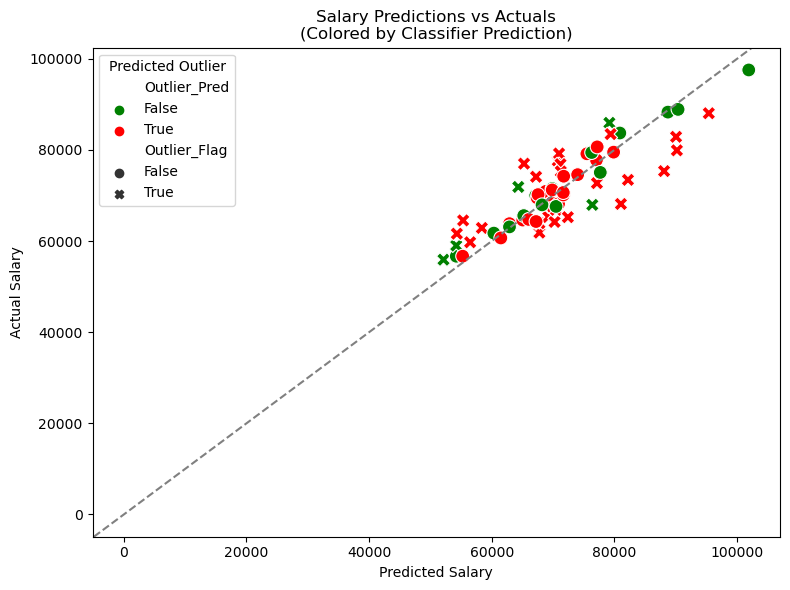

In [182]:
# -------------------
# Visualization
# -------------------
df["Outlier_Prob"] = clf.predict_proba(X_class)[:, 1]
df["Outlier_Pred"] = df["Outlier_Prob"] > 0.4

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="25-26 Salary",
    y="Prediction",
    hue="Outlier_Pred",
    palette={True: "red", False: "green"},
    style="Outlier_Flag",
    markers={True: "X", False: "o"},
    s=100
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.title("Salary Predictions vs Actuals\n(Colored by Classifier Prediction)")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [183]:
from sklearn.model_selection import RepeatedKFold, cross_validate

# Filter to only rows *not* flagged as outliers
df_clean = df[~df["Outlier_Flag"]].copy()

# Match index of rows not flagged as outliers
clean_indices = df_clean.index

# Ensure we use the same features as original X
features_to_use = X.columns.tolist()

# Rebuild X and y using just those rows and the exact same features
X_clean = df_encoded.loc[clean_indices, features_to_use]
y_clean = df.loc[clean_indices, "25-26 Salary"]

# Set up repeated cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=25, random_state=42)

# Ridge model (alpha = 1)
a = 1
model_noOuts = Ridge(alpha=a)

# Run CV
scores = cross_validate(
    model_noOuts,
    X_clean,
    y_clean,
    cv=rkf,
    scoring=('r2', 'neg_mean_squared_error'),
    return_train_score=False
)

# Analyze results
r2_scores = scores["test_r2"]
rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5

# Display
print("\n🧪 Ridge Regression Cross-Validation (Excluding Outliers):")
print(f"Used {len(X_clean):,} data points for training after outlier exclusion.\n")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")


🧪 Ridge Regression Cross-Validation (Excluding Outliers):
Used 37 data points for training after outlier exclusion.

Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
1     	0.7974		0.2277		2,899.83		603.38


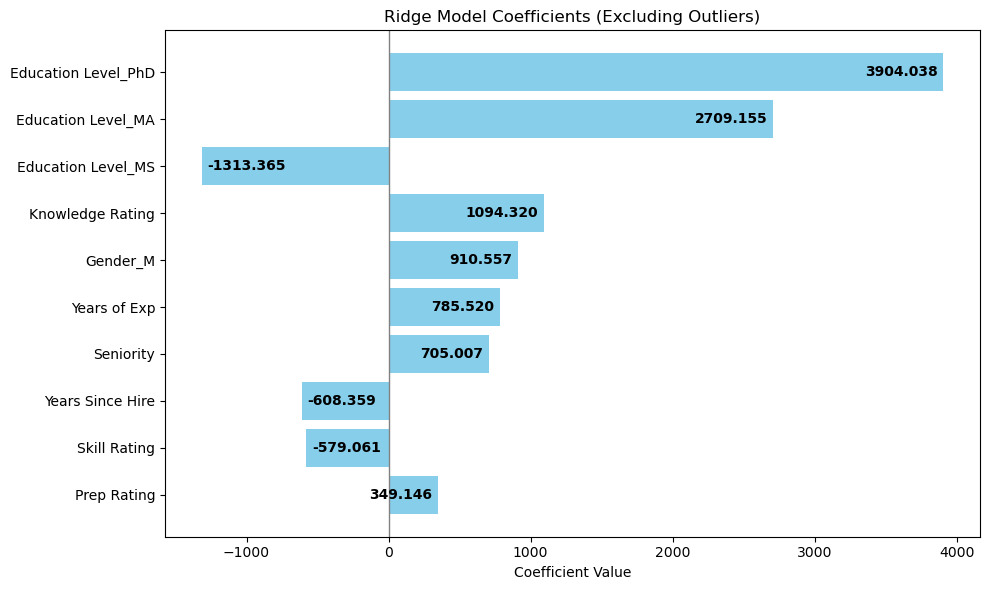

In [184]:
import matplotlib.pyplot as plt

# Fit the model on cleaned data (if not already done)
model_noOuts = Ridge(alpha=1.0)
model_noOuts.fit(X_clean, y_clean)

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    "Feature": X_clean.columns,
    "Coefficient": model_noOuts.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="skyblue")

# Add text labels inside the bars
for bar, coef in zip(bars, coef_df["Coefficient"]):
    width = bar.get_width()
    text = f"{coef:.3f}"
    xpos = width - 0.01 * max(abs(coef_df["Coefficient"])) if width > 0 else width + 0.01 * max(abs(coef_df["Coefficient"]))
    align = "right" if width > 0 else "left"
    plt.text(
        xpos,
        bar.get_y() + bar.get_height() / 2,
        text,
        va="center",
        ha=align,
        color="black",
        fontweight="bold"
    )

plt.axvline(0, color="gray", linewidth=1)
plt.title("Ridge Model Coefficients (Excluding Outliers)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

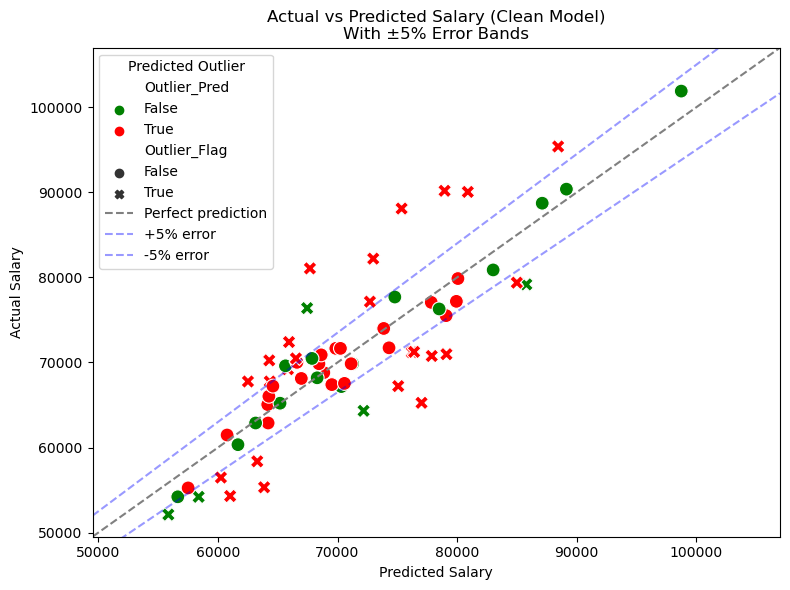

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict using the clean model
X_predict = df_encoded[model_noOuts.feature_names_in_]
df["Prediction_from_clean_model"] = model_noOuts.predict(X_predict)

# Plot setup
plt.figure(figsize=(8, 6))

# Scatterplot: color = predicted outlier, shape = true outlier
sns.scatterplot(
    data=df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    hue="Outlier_Pred",
    style="Outlier_Flag",
    palette={True: "red", False: "green"},
    markers={True: "X", False: "o"},
    s=100
)

# Reference lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]

x_vals = np.linspace(lims[0], lims[1], 100)
plt.plot(x_vals, x_vals, "--", color="gray", label="Perfect prediction")
plt.plot(x_vals, x_vals * 1.05, "--", color="blue", alpha=0.4, label="+5% error")
plt.plot(x_vals, x_vals * 0.95, "--", color="blue", alpha=0.4, label="-5% error")

# Labels and layout
plt.title("Actual vs Predicted Salary (Clean Model)\nWith ±5% Error Bands")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [186]:
import plotly.express as px
import numpy as np

# Calculate residual info (if not already done)
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = df["Residual"] / df["25-26 Salary"]
df["Residual % (abs)"] = df["Residual %"].abs() * 100  # for display
df["Outlier_Pred_Label"] = df["Outlier_Pred"].map({True: "Flagged", False: "Normal"})
df["Outlier_True_Label"] = df["Outlier_Flag"].map({True: "Actual Outlier", False: "Not Outlier"})

# Optional: dummy label for anonymity
df["Label"] = df.index.astype(str)

# Base plot
fig = px.scatter(
    df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    color="Outlier_Pred_Label",
    symbol="Outlier_True_Label",
    hover_data={
        "Label": True,
        "25-26 Salary": True,
        "Prediction_from_clean_model": True,
        "Residual": ":.0f",
        "Residual % (abs)": ":.1f",
        "Outlier_Pred_Label": False,
        "Outlier_True_Label": False,
    },
    labels={
        "Prediction_from_clean_model": "Predicted Salary",
        "25-26 Salary": "Actual Salary"
    },
    title="Interactive Actual vs Predicted Salary<br>Colored by Predicted Outlier, Symbol by Actual Outlier"
)

# Add ±5% error lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]
x_vals = np.linspace(lims[0], lims[1], 100)

fig.add_scatter(
    x=x_vals, y=x_vals,
    mode='lines', line=dict(dash='dash', color='gray'),
    name='Perfect Prediction'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 1.05,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='+5% Error'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 0.95,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='-5% Error'
)

# Final layout
fig.update_layout(
    xaxis_title="Predicted Salary",
    yaxis_title="Actual Salary",
    legend_title="Predicted Outlier",
    width=900,
    height=600
)

fig.show()

In [187]:
# --------------------------------------------
# Top largest residuals (actual vs predicted)
# --------------------------------------------

# Ensure residuals are computed
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = (df["Residual"] / df["25-26 Salary"]).abs()

# Sort by absolute residual percentage
top_residuals = df.sort_values("Residual %", ascending=False).copy()

# Choose how many you want to display
n = 10

# Format numeric columns with commas (no decimals)
top_residuals["25-26 Salary (formatted)"] = top_residuals["25-26 Salary"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Predicted Salary (formatted)"] = top_residuals["Prediction_from_clean_model"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual (formatted)"] = top_residuals["Residual"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual % (formatted)"] = top_residuals["Residual %"].apply(lambda x: f"{x*100:.1f}%")

# Columns to show
display_cols = [
    "25-26 Salary (formatted)",
    "Predicted Salary (formatted)",
    "Residual (formatted)",
    "Residual % (formatted)",
    "Outlier_Flag",
    "Outlier_Pred",
    "Outlier_Prob"
]

# Show top n
top_residuals[display_cols].head(n)

,25-26 Salary (formatted),Predicted Salary (formatted),Residual (formatted),Residual % (formatted),Outlier_Flag,Outlier_Pred,Outlier_Prob
63,"65,259","77,023","-11,764",18.0%,True,True,0.534499
60,"81,055","67,693","13,362",16.5%,True,True,0.472913
12,"55,328","63,862","-8,534",15.4%,True,True,0.443997
68,"88,090","75,355","12,735",14.5%,True,True,0.531097
69,"90,178","78,950","11,228",12.5%,True,True,0.456880
4,"54,302","61,022","-6,720",12.4%,True,True,0.459311
35,"64,318","72,179","-7,861",12.2%,True,False,0.269654
33,"76,387","67,457","8,930",11.7%,True,False,0.346153
39,"67,220","75,073","-7,853",11.7%,True,True,0.615450
48,"70,967","79,106","-8,139",11.5%,True,True,0.610172


In [188]:
import shap
import pandas as pd

# Choose target row
target_index = 42

# Make sure the row is a DataFrame (not just values) to preserve feature names
x_target = X_clean.loc[[target_index]]

# Use SHAP KernelExplainer (model-agnostic)
explainer = shap.KernelExplainer(model_noOuts.predict, X_clean)

# Compute SHAP values for this 1-row DataFrame
shap_values = explainer.shap_values(x_target)

# Format into a DataFrame
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
}).sort_values("SHAP Impact", key=abs, ascending=False)

# Extra formatting for clarity
shap_df["Direction"] = shap_df["SHAP Impact"].apply(lambda x: "↑ raises" if x > 0 else "↓ lowers")
shap_df["SHAP Impact"] = shap_df["SHAP Impact"].map(lambda x: f"{x:,.0f}")

# Show result
print(f"📌 SHAP Breakdown for Index {target_index}")
print(f"Predicted Salary: {model_noOuts.predict(x_target)[0]:,.0f}")
print(f"Baseline Prediction (expected value): {explainer.expected_value:.0f}\n")
print(shap_df[["Feature", "Value", "SHAP Impact", "Direction"]].head(12).to_string(index=False))

  0%|          | 0/1 [00:00<?, ?it/s]

📌 SHAP Breakdown for Index 42
Predicted Salary: 68,296
Baseline Prediction (expected value): 71156

            Feature Value SHAP Impact Direction
          Seniority   1.0      -4,306  ↓ lowers
   Years Since Hire     0       3,732  ↑ raises
       Years of Exp    12      -2,123  ↓ lowers
       Skill Rating     8      -2,113  ↓ lowers
 Education Level_MA  True       1,025  ↑ raises
   Knowledge Rating     5         887  ↑ raises
           Gender_M  True         591  ↑ raises
        Prep Rating     0        -377  ↓ lowers
Education Level_PhD False        -211  ↓ lowers
 Education Level_MS False          35  ↑ raises


In [194]:
import plotly.express as px
import shap
import pandas as pd

# Set the original index from df (can be anything in df)
original_index = 4  # 👈 change this to whichever row you want to explain

# Make sure that row exists
if original_index not in df_encoded.index:
    raise ValueError(f"Index {original_index} not found in original data!")

# Match exact features used for training
x_target = df_encoded.loc[[original_index], X_clean.columns]

# SHAP: Use KernelExplainer (you already fit model_noOuts earlier)
explainer = shap.KernelExplainer(model_noOuts.predict, X_clean)
shap_values = explainer.shap_values(x_target)

# Create SHAP DataFrame for display
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
})
shap_df["Abs Impact"] = shap_df["SHAP Impact"].abs()
shap_df["Impact Direction"] = shap_df["SHAP Impact"].apply(lambda x: "Raises Prediction" if x > 0 else "Lowers Prediction")
shap_df = shap_df.sort_values("Abs Impact", ascending=True)

baseline = float(explainer.expected_value)  # ensure it's a plain number
title = (
    f"🔍 SHAP Explanation for Index {original_index}<br>"
    f"Predicted: ${model_noOuts.predict(x_target)[0]:,.0f} | "
    f"Baseline: ${baseline:,.0f}"
)

# Interactive plot
fig = px.bar(
    shap_df,
    x="SHAP Impact",
    y="Feature",
    orientation="h",
    color="Impact Direction",
    hover_data={
        "Value": True,
        "SHAP Impact": True,
        "Feature": False,
        "Impact Direction": False
    },
    title=title,
    color_discrete_map={
        "Raises Prediction": "green",
        "Lowers Prediction": "red"
    }
)

fig.update_layout(
    xaxis_title="SHAP Impact on Prediction",
    yaxis_title="Feature",
    height=500
)

fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Prepare HR export DataFrame
hr_export = df.copy()

# Format numeric columns
hr_export["Predicted Salary"] = df["Prediction_from_clean_model"].round(0)
hr_export["Residual"] = (df["25-26 Salary"] - df["Prediction_from_clean_model"]).round(0)
hr_export["Residual %"] = ((hr_export["Residual"] / df["25-26 Salary"]) * 100).round(1)

# Flag columns
hr_export["Recommended for Review"] = df["Outlier_Pred"]
hr_export["Actual Outlier"] = df["Outlier_Flag"]
hr_export["Model Confidence (Outlier %)"] = (df["Outlier_Prob"] * 100).round(1)

# Optional: reformat currency-style columns for HR
for col in ["25-26 Salary", "Predicted Salary", "Residual"]:
    hr_export[col] = hr_export[col].apply(lambda x: f"${int(x):,}" if pd.notnull(x) else "")

# Reorder columns to put essentials first
key_columns = [
    "25-26 Salary", "Predicted Salary", "Residual", "Residual %",
    "Recommended for Review", "Model Confidence (Outlier %)", "Actual Outlier"
]
other_columns = [col for col in hr_export.columns if col not in key_columns]
hr_export = hr_export[key_columns + other_columns]

# Sort by % error: lowest residuals (underpaid) at top
hr_export_sorted = hr_export.sort_values("Residual %")

# Export
hr_export_sorted.to_csv("salary_model_output_for_HR_sorted.csv", index=False)

print("✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %)")

✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %)
